In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import typing
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
from typing import Union, List, Tuple
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors3D
from rdkit.Chem import GraphDescriptors
from tqdm import tqdm

RDKit WARNING: [12:43:14] Enabling RDKit 2019.09.1 jupyter extensions
[12:43:14] Enabling RDKit 2019.09.1 jupyter extensions


In [2]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neural_network import MLPRegressor
from sklearn.inspection import permutation_importance

In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
from sklearn.utils import resample
import itertools

In [4]:
import statistics as s

### Helper functions

In [5]:
def find_pattern_count(molecule: Chem.Mol, pattern: Chem.Mol) -> int:
    result = molecule.GetSubstructMatches(pattern)
    return len(result)

def drawSmils(smils: str):
    smilsChromoChem = Chem.MolFromSmiles(smils)
    drawing = Draw.MolToMPL(smilsChromoChem, size=(450,450))


# Read data

In [6]:
qm9_database = pd.read_csv("qm9.csv")
qm9_database["RDKit_Mol_Class"] = qm9_database["smiles"].apply(Chem.MolFromSmiles)
only_solids = pd.read_json("only_solids_features.json").reset_index(drop=True)
only_solids_conf = pd.read_json("only_solids_conf_features.json").reset_index(drop=True)
only_solids["RDKit_Mol_Class"] = only_solids["Chromophore"].apply(Chem.MolFromSmiles)
only_solids_conf["RDKit_Mol_Class"] = only_solids_conf["Chromophore"].apply(Chem.MolFromSmiles)

In [7]:
first_4_cols = ["Chromophore", 'qm9_pattern_indexes', 'RDKit_Mol_Class', "Emission max (nm)"]
only_solids = pd.concat([only_solids[first_4_cols], only_solids.drop(columns=first_4_cols)], axis=1)
only_solids_conf = pd.concat([only_solids_conf[first_4_cols], only_solids_conf.drop(columns=first_4_cols)], axis=1)

In [8]:
descriptors_names = [ x[0] for x in Descriptors._descList ]
len(descriptors_names)

200

In [9]:
scaler = StandardScaler()
scaler.fit(only_solids[descriptors_names])
only_solids = pd.concat([only_solids[only_solids.columns.drop(descriptors_names)].reset_index(drop=True), pd.DataFrame(scaler.transform(only_solids[descriptors_names]), columns=descriptors_names)], axis=1)

In [10]:
only_solids.drop(only_solids.std()[only_solids.std()==0].index, axis=1, inplace=True)
only_solids.shape

/tmp/ipykernel_27329/88905139.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  only_solids.drop(only_solids.std()[only_solids.std()==0].index, axis=1, inplace=True)


(956, 1312)

In [11]:
nans_cols = only_solids.columns[only_solids.isna().any()]
nans_cols

Index(['Emission max (nm)', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI',
       'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI',
       'BCUT2D_MRLOW', 'MaxPartialCharge', 'MinPartialCharge',
       'MaxAbsPartialCharge', 'MinAbsPartialCharge'],
      dtype='object')

In [12]:
only_solids.dropna(subset=nans_cols, axis=0, inplace=True)
only_solids.shape

(896, 1312)

In [13]:
universal_features = list(only_solids.columns)[4:]
universal_features_conf = list(only_solids_conf.columns)[4:]

In [14]:
model_data_conf_x = only_solids[universal_features]
model_data_conf_y = only_solids["Emission max (nm)"]

In [15]:
all_quantum_features = list(qm9_database.columns.drop(["RDKit_Mol_Class", "mol_id", "smiles"]))

In [16]:
imp_scores = {}

# Model 1

In [17]:
rfr1 = RandomForestRegressor(random_state=0)

linear_model = LinearRegression()

reg = GradientBoostingRegressor(random_state=0)

In [18]:
rfr1 = RandomForestRegressor(
    max_depth=10,
#                                 max_features=300,
                                min_samples_leaf=20,
                                n_estimators=400
)

linear_model = LinearRegression()

reg = GradientBoostingRegressor(
    learning_rate=0.05,
                                max_depth=4,
#                                 max_features=300,
#                                 min_samples_leaf=20,
                                n_estimators=1000,
    random_state=0
)

In [19]:
lin_model1_features = list(set(model_data_conf_x.columns) & set(descriptors_names))

In [20]:
maes = []
most_imp_feat = pd.DataFrame()
for _ in tqdm(range(100)):
    res_x, res_y = resample(model_data_conf_x, model_data_conf_y)
    oob_idx = set(model_data_conf_y.index).difference(set(res_x.index))
    reg.fit(res_x, res_y)
    x_test, y_test = model_data_conf_x.loc[list(oob_idx),:], model_data_conf_y.loc[list(oob_idx)]
    r = permutation_importance(reg, x_test, y_test,
                            n_repeats=5,
                            )
    mif = [[], []]
    for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
#         if r.importances_mean[i] - r.importances_std[i] > 0:
#         if r.importances_mean[i] > 0:
            mif[0].append(f"{res_x.columns[i]}")
            mif[1].append(r.importances_mean[i])
    most_imp_feat = pd.concat([most_imp_feat, pd.Series(mif[1], index=mif[0])], axis=1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [3:54:56<00:00, 140.97s/it]


In [21]:
most_ranked = most_imp_feat.dropna()
most_imp_feat.fillna(0, inplace=True)
most_imp_feat.columns = range(most_imp_feat.shape[1])

In [22]:
imp_scores["model1"] = {"most_ranked": most_ranked,
                       "most_imp_feat": most_imp_feat.to_dict()}

In [23]:
most_ranked

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MACCS_key99,0.061757,0.039008,0.158327,0.151273,0.116204,0.102329,0.142497,0.206863,0.180418,0.125223,...,0.141062,0.098748,0.087479,0.117578,0.118131,0.111685,0.135083,0.11966,0.146167,0.12216


In [24]:
most_imp_feat["max"] = most_imp_feat.apply(max, axis=1)
most_imp_feat["mean"] = most_imp_feat.apply(np.mean, axis=1)

In [25]:
mst = most_imp_feat.sort_values(by="mean", ascending=False).head(150).index
most_imp_feat.sort_values(by="mean", ascending=False).head(20)

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,max,mean
MACCS_key99,0.061757,0.039008,0.158327,0.151273,0.116204,0.102329,0.142497,0.206863,0.180418,0.125223,...,0.087479,0.117578,0.118131,0.111685,0.135083,0.119660,0.146167,0.122160,0.267679,0.150554
qed,0.050586,0.060762,0.030887,0.033257,0.085213,0.104550,0.032294,0.065255,0.035654,0.027811,...,0.097122,0.070075,0.112642,0.035028,0.116233,0.063931,0.063404,0.030238,0.160029,0.055301
VSA_EState2,0.025485,0.015794,0.039114,0.012547,0.028194,0.008716,0.040024,0.017707,0.042751,0.043232,...,0.039498,0.000000,0.010986,0.027579,0.017118,0.019547,0.022199,0.019386,0.058766,0.024951
SlogP_VSA10,0.037747,0.046701,0.003416,0.000000,0.028034,0.049785,0.009447,0.020817,0.011169,0.007564,...,0.026427,0.032066,0.040954,0.011446,0.000000,0.009538,0.040671,0.023817,0.069105,0.024922
TPSA,0.027285,0.021706,0.061693,0.031174,0.043705,0.030470,0.033313,0.015678,0.000000,0.022663,...,0.017807,0.022246,0.031447,0.036944,0.037794,0.056193,0.008919,0.065750,0.087123,0.023197
NOCount,0.000000,0.004712,0.017258,0.009918,0.012014,0.007992,0.023028,0.019748,0.034601,0.031913,...,0.007240,0.003025,0.008269,0.017889,0.023616,0.000000,0.025495,0.000000,0.063118,0.015710
PEOE_VSA4,0.052786,0.020879,0.000000,0.057249,0.003129,0.000000,0.033758,0.026128,0.008332,0.000000,...,0.002299,0.000000,0.000000,0.009453,0.006332,0.015014,0.022265,0.006301,0.081594,0.014860
MorganFP_bit_616,0.000000,0.024928,0.021820,0.004100,0.015850,0.016286,0.028110,0.003298,0.018526,0.022123,...,0.062530,0.052921,0.000000,0.015967,0.014546,0.009486,0.023494,0.015734,0.068798,0.014462
SMR_VSA10,0.000000,0.012803,0.005836,0.026610,0.003809,0.014229,0.009781,0.000000,0.013527,0.032311,...,0.007138,0.000000,0.000000,0.016068,0.014943,0.016560,0.000000,0.006098,0.036628,0.012844
SMR_VSA6,0.000000,0.016264,0.000000,0.000000,0.024940,0.002502,0.017107,0.028698,0.022843,0.018480,...,0.000000,0.026573,0.016808,0.004740,0.000000,0.027354,0.005327,0.020102,0.055188,0.012554


In [26]:
most_imp_feat

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,max,mean
MACCS_key99,0.061757,0.039008,0.158327,0.151273,0.116204,0.102329,0.142497,0.206863,0.180418,0.125223,...,0.087479,0.117578,0.118131,0.111685,0.135083,1.196598e-01,0.146167,0.122160,2.676789e-01,1.505539e-01
PEOE_VSA4,0.052786,0.020879,0.000000,0.057249,0.003129,0.000000,0.033758,0.026128,0.008332,0.000000,...,0.002299,0.000000,0.000000,0.009453,0.006332,1.501422e-02,0.022265,0.006301,8.159350e-02,1.486032e-02
qed,0.050586,0.060762,0.030887,0.033257,0.085213,0.104550,0.032294,0.065255,0.035654,0.027811,...,0.097122,0.070075,0.112642,0.035028,0.116233,6.393086e-02,0.063404,0.030238,1.600289e-01,5.530087e-02
SlogP_VSA10,0.037747,0.046701,0.003416,0.000000,0.028034,0.049785,0.009447,0.020817,0.011169,0.007564,...,0.026427,0.032066,0.040954,0.011446,0.000000,9.538079e-03,0.040671,0.023817,6.910525e-02,2.492239e-02
TPSA,0.027285,0.021706,0.061693,0.031174,0.043705,0.030470,0.033313,0.015678,0.000000,0.022663,...,0.017807,0.022246,0.031447,0.036944,0.037794,5.619251e-02,0.008919,0.065750,8.712307e-02,2.319727e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MorganFP_bit_524,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.172366e-05,0.000000,0.000000,1.172366e-05,2.321517e-07
MorganFP_bit_447,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,6.165385e-06,0.000000,0.000000,6.165385e-06,1.220868e-07
MorganFP_bit_889,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2.331706e-06,0.000000,0.000000,2.331706e-06,4.617239e-08
MorganFP_bit_553,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,6.023369e-07,0.000000,0.000000,6.023369e-07,1.192746e-08


In [27]:
sm = most_imp_feat.iloc[:,-1].sum()

In [28]:
most_imp_feat["percent"] = most_imp_feat["mean"]/sm

In [29]:
most_imp_feat["percent"][:10]*100

MACCS_key99         26.704344
PEOE_VSA4            2.635833
qed                  9.808931
SlogP_VSA10          4.420583
TPSA                 4.114591
VSA_EState2          4.425739
PEOE_VSA8            1.176473
MorganFP_bit_724     0.773783
BCUT2D_MRLOW         0.843377
SlogP_VSA3           0.153100
Name: percent, dtype: float64

In [30]:
mst = most_imp_feat[(most_imp_feat["mean"] > 0.0001)].index
len(mst)

254

In [31]:
mst = most_imp_feat.sort_values(by="mean", ascending=False).head(150).index

In [32]:
model_data_conf_x = only_solids[list(mst)]
model_data_conf_y = only_solids["Emission max (nm)"]

In [33]:
error = []
for _ in tqdm(range(1000)):
    res_x, res_y = resample(model_data_conf_x, model_data_conf_y)
    oob_idx = set(model_data_conf_y.index).difference(set(res_x.index))
    reg.fit(res_x, res_y)
    oob_pred = reg.predict(model_data_conf_x.loc[list(oob_idx),:])
    error.append(model_data_conf_y.loc[list(oob_idx)] - oob_pred)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [3:32:48<00:00, 12.77s/it]


In [34]:
import itertools
errors = np.array(list(itertools.chain.from_iterable(error)))

In [35]:
imp_scores["model1"]["errors"] = list(errors)

<AxesSubplot:ylabel='Count'>

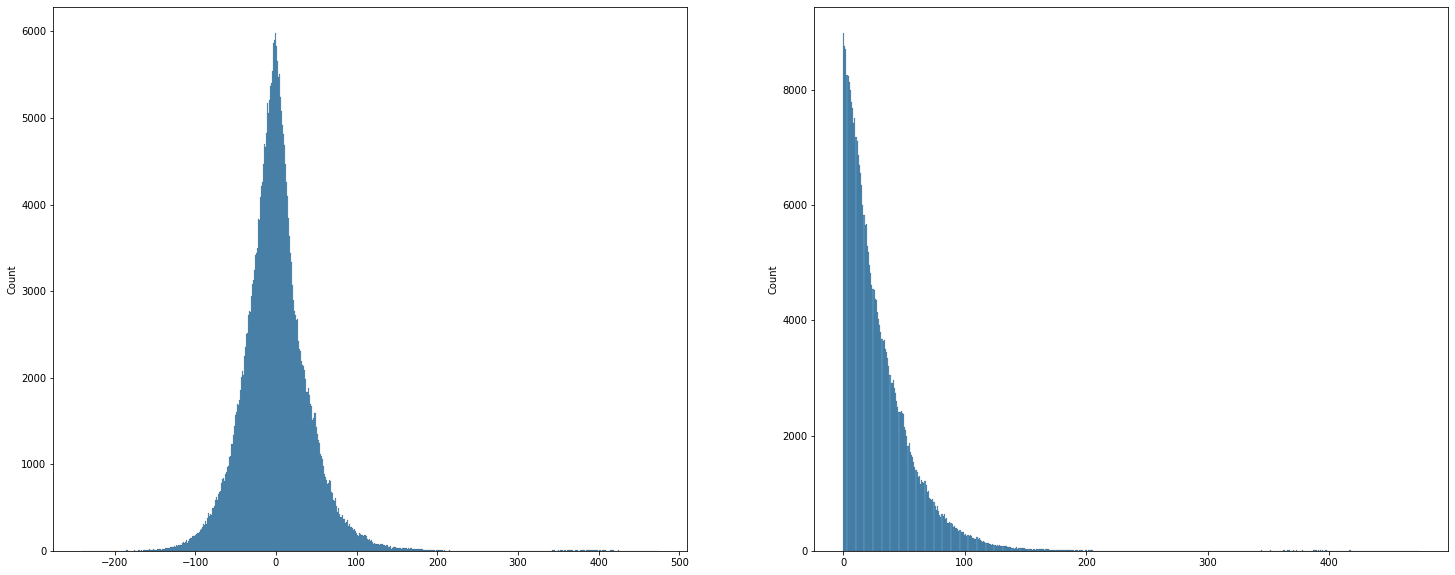

In [36]:
fig, ax = plt.subplots(1,2, figsize=(25, 10))
sns.histplot(errors, ax=ax[0])
sns.histplot(np.abs(errors), ax=ax[1])

In [37]:
s.stdev(errors)

41.56050146791665

In [38]:
np.percentile(errors, 5), np.percentile(errors, 95)

(-62.794972730534056, 67.26881587471055)

In [39]:
abserrors = np.abs(errors)
np.percentile(abserrors, 5), np.percentile(abserrors, 95)

(1.7227472255141383, 82.36532485571084)

In [40]:
np.median(abserrors), np.mean(abserrors)

(21.529675352098707, 29.52638809636652)

# Model 2

In [41]:
def get_features(row, database: pd.DataFrame, features: Union[List[str], str]) -> None:
    for index in row["qm9_pattern_indexes"]:
        count = find_pattern_count(row["RDKit_Mol_Class"], database["RDKit_Mol_Class"][index])
        for feature in features:
            value = count*database[feature][index]
            row[feature] += value
    return row

In [42]:
features = all_quantum_features

In [43]:
only_solids[features] = 0

In [44]:
only_solids = only_solids.apply(get_features, database=qm9_database, features=features, axis=1)

In [45]:
model_data_conf_x = only_solids[universal_features+features]
model_data_conf_y = only_solids["Emission max (nm)"]

In [46]:
linear_model2 = LinearRegression()

In [47]:
lin_model1_features = list(set(model_data_conf_x.columns) & set(descriptors_names))

In [48]:
maes = []
most_imp_feat = pd.DataFrame()
for _ in tqdm(range(100)):
    res_x, res_y = resample(model_data_conf_x, model_data_conf_y)
    oob_idx = set(model_data_conf_y.index).difference(set(res_x.index))
    reg.fit(res_x, res_y)
    x_test, y_test = model_data_conf_x.loc[list(oob_idx),:], model_data_conf_y.loc[list(oob_idx)]
    r = permutation_importance(reg, x_test, y_test,
                            n_repeats=5,
                            )
    mif = [[], []]
    for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
#         if r.importances_mean[i] - r.importances_std[i] > 0:
#         if r.importances_mean[i] > 0:
            mif[0].append(f"{res_x.columns[i]}")
            mif[1].append(r.importances_mean[i])
    most_imp_feat = pd.concat([most_imp_feat, pd.Series(mif[1], index=mif[0])], axis=1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [4:01:06<00:00, 144.67s/it]


In [49]:
most_ranked = most_imp_feat.dropna()
most_imp_feat.fillna(0, inplace=True)
most_imp_feat.columns = range(most_imp_feat.shape[1])

In [50]:
imp_scores["model2"] = {"most_ranked": most_ranked,
                       "most_imp_feat": most_imp_feat.to_dict()}

In [51]:
most_ranked

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MACCS_key99,0.230036,0.087056,0.224112,0.107986,0.240491,0.196524,0.114946,0.246778,0.1914,0.202796,...,0.106349,0.111541,0.18585,0.147187,0.131806,0.133285,0.182859,0.141506,0.146842,0.143701


In [52]:
most_imp_feat["max"] = most_imp_feat.apply(max, axis=1)
most_imp_feat["mean"] = most_imp_feat.apply(np.mean, axis=1)

In [53]:
mst = most_imp_feat.sort_values(by="mean", ascending=False).head(150).index
most_imp_feat.sort_values(by="mean", ascending=False).head(20)

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,max,mean
MACCS_key99,0.230036,0.087056,0.224112,0.107986,0.240491,0.196524,0.114946,0.246778,0.191400,0.202796,...,0.185850,0.147187,0.131806,0.133285,0.182859,0.141506,0.146842,0.143701,0.256825,0.161741
qed,0.047427,0.130406,0.041547,0.088882,0.020186,0.076410,0.034196,0.032486,0.077193,0.065730,...,0.059227,0.061578,0.128996,0.022134,0.045134,0.056597,0.046258,0.086816,0.149417,0.051727
VSA_EState2,0.016641,0.029284,0.029201,0.040132,0.023036,0.014149,0.024278,0.023826,0.015929,0.027177,...,0.046033,0.014980,0.016189,0.039582,0.031773,0.032277,0.026073,0.014438,0.065168,0.028155
SlogP_VSA10,0.058519,0.000000,0.025703,0.036828,0.050919,0.026487,0.031550,0.024354,0.020016,0.047154,...,0.035481,0.025453,0.029433,0.022502,0.029975,0.020635,0.015396,0.034933,0.079375,0.027412
TPSA,0.016815,0.074692,0.000000,0.018407,0.004581,0.017924,0.011343,0.014519,0.000000,0.016853,...,0.008372,0.018730,0.026172,0.028320,0.026765,0.098965,0.037252,0.036983,0.098965,0.021919
PEOE_VSA4,0.016188,0.019187,0.045031,0.020757,0.018875,0.016838,0.044603,0.031703,0.009885,0.013228,...,0.036095,0.043871,0.011476,0.000000,0.001190,0.012883,0.036239,0.010038,0.078323,0.019152
NOCount,0.043466,0.000000,0.044170,0.000000,0.048118,0.036969,0.000000,0.036345,0.014276,0.007599,...,0.018748,0.007663,0.009694,0.013960,0.026741,0.000139,0.004984,0.002700,0.055228,0.016468
MorganFP_bit_616,0.016499,0.003004,0.021832,0.000000,0.003584,0.013388,0.008909,0.000000,0.014883,0.010650,...,0.024017,0.009172,0.005424,0.008546,0.000000,0.012825,0.004913,0.017826,0.057308,0.014648
SMR_VSA6,0.011138,0.000000,0.036537,0.022523,0.018835,0.027256,0.010798,0.031456,0.000000,0.027076,...,0.000000,0.010792,0.000741,0.011857,0.008058,0.037212,0.011695,0.011508,0.071016,0.013011
SMR_VSA10,0.005730,0.020584,0.015483,0.013776,0.008241,0.011325,0.023138,0.009503,0.010094,0.024371,...,0.009097,0.023882,0.009291,0.009496,0.011946,0.000000,0.018330,0.017965,0.025823,0.010930


In [54]:
most_imp_feat

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,max,mean
MACCS_key99,0.230036,0.087056,0.224112,0.107986,0.240491,0.196524,0.114946,0.246778,0.191400,0.202796,...,0.185850,0.147187,0.131806,0.133285,0.182859,0.141506,0.146842,0.143701,0.256825,1.617411e-01
SlogP_VSA10,0.058519,0.000000,0.025703,0.036828,0.050919,0.026487,0.031550,0.024354,0.020016,0.047154,...,0.035481,0.025453,0.029433,0.022502,0.029975,0.020635,0.015396,0.034933,0.079375,2.741159e-02
qed,0.047427,0.130406,0.041547,0.088882,0.020186,0.076410,0.034196,0.032486,0.077193,0.065730,...,0.059227,0.061578,0.128996,0.022134,0.045134,0.056597,0.046258,0.086816,0.149417,5.172689e-02
NOCount,0.043466,0.000000,0.044170,0.000000,0.048118,0.036969,0.000000,0.036345,0.014276,0.007599,...,0.018748,0.007663,0.009694,0.013960,0.026741,0.000139,0.004984,0.002700,0.055228,1.646750e-02
MorganFP_bit_122,0.021584,0.000271,0.006371,0.003925,0.025745,0.002249,0.000000,0.000000,0.000000,0.001437,...,0.004565,0.003654,0.002285,0.009424,0.000000,0.004063,0.004757,0.001897,0.031066,5.641057e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MorganFP_bit_20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000,0.000001,2.738665e-08
MorganFP_bit_234,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000001,0.000000,0.000000,0.000000,0.000000,0.000001,2.456836e-08
MorganFP_bit_109,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000093,0.000000,0.000000,0.000093,1.837979e-06
MorganFP_bit_295,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000311,0.000000,0.000311,6.150814e-06


In [55]:
sm = most_imp_feat.iloc[:,-1].sum()

In [56]:
most_imp_feat["percent"] = most_imp_feat["mean"]/sm

In [57]:
most_imp_feat["percent"][:10]*100

MACCS_key99         27.650386
SlogP_VSA10          4.686137
qed                  8.842950
NOCount              2.815196
MorganFP_bit_122     0.964365
TPSA                 3.747170
VSA_EState2          4.813187
MorganFP_bit_616     2.504203
PEOE_VSA4            3.274175
PEOE_VSA8            1.244636
Name: percent, dtype: float64

In [58]:
mst = most_imp_feat[(most_imp_feat["mean"] > 0.0001)].index
len(mst)

249

In [59]:
mst = most_imp_feat.sort_values(by="mean", ascending=False).head(150).index

In [60]:
model_data_conf_x = only_solids[list(mst)]
model_data_conf_y = only_solids["Emission max (nm)"]

In [61]:
error = []
for _ in tqdm(range(1000)):
    res_x, res_y = resample(model_data_conf_x, model_data_conf_y)
    oob_idx = set(model_data_conf_y.index).difference(set(res_x.index))
    reg.fit(res_x, res_y)
    oob_pred = reg.predict(model_data_conf_x.loc[list(oob_idx),:])
    error.append(model_data_conf_y.loc[list(oob_idx)] - oob_pred)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [3:33:23<00:00, 12.80s/it]


In [62]:
import itertools
errors = np.array(list(itertools.chain.from_iterable(error)))

In [63]:
imp_scores["model2"]["errors"] = list(errors)

<AxesSubplot:ylabel='Count'>

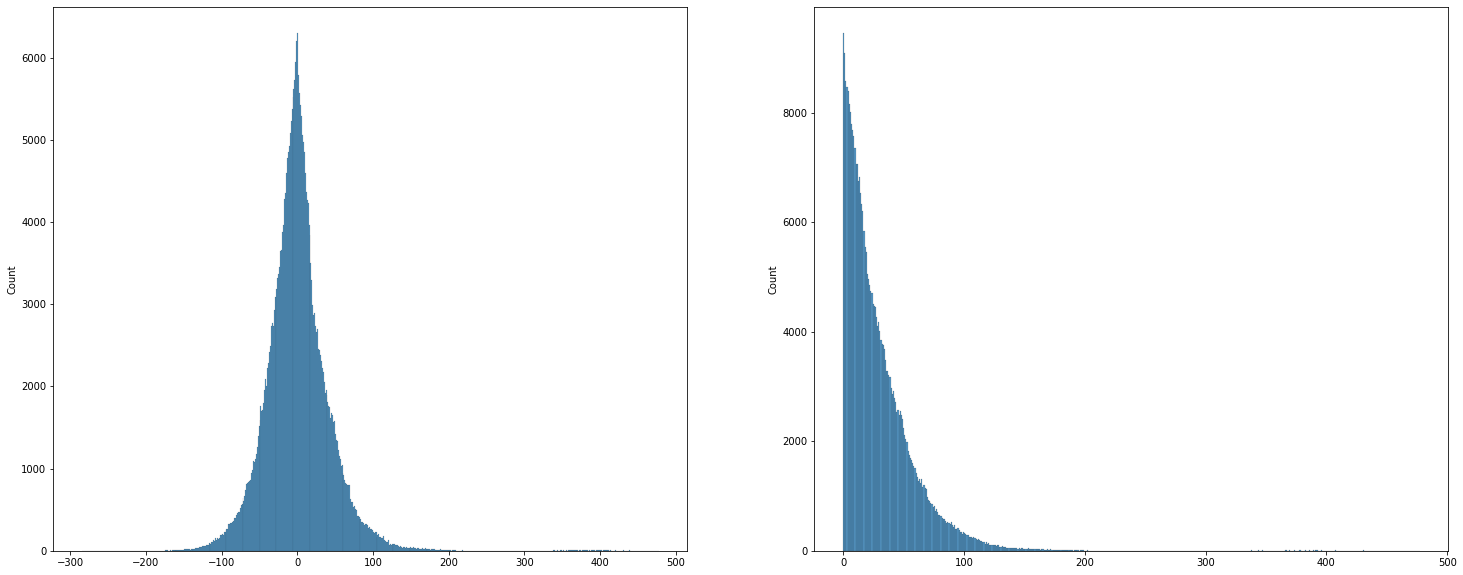

In [64]:
fig, ax = plt.subplots(1,2, figsize=(25, 10))
sns.histplot(errors, ax=ax[0])
sns.histplot(np.abs(errors), ax=ax[1])

In [65]:
s.stdev(errors)

41.75186840185708

In [66]:
np.percentile(errors, 5), np.percentile(errors, 95)

(-63.106724268340486, 67.48468865584454)

In [67]:
abserrors = np.abs(errors)
np.percentile(abserrors, 5), np.percentile(abserrors, 95)

(1.6548763375050726, 83.06705769140177)

In [68]:
np.median(abserrors), np.mean(abserrors)

(21.671213082101076, 29.63126349727311)

# Model 3

In [69]:
def get_features(row, database: pd.DataFrame, features: Union[List[str], str]) -> None:
    for index in row["qm9_pattern_indexes"]:
        count = find_pattern_count(row["RDKit_Mol_Class"], database["RDKit_Mol_Class"][index])
        for feature in features:
            value = database[feature][index]*count
            row[feature] += value
    return row

In [70]:
features = all_quantum_features

In [71]:
only_solids[features] = 0

In [72]:
only_solids = only_solids.apply(get_features, database=qm9_database, features=features, axis=1)

In [73]:
model_data_conf_x = only_solids[features]
model_data_conf_y = only_solids["Emission max (nm)"]

In [74]:
maes = []
most_imp_feat = pd.DataFrame()
for _ in tqdm(range(100)):
    res_x, res_y = resample(model_data_conf_x, model_data_conf_y)
    oob_idx = set(model_data_conf_y.index).difference(set(res_x.index))
    reg.fit(res_x, res_y)
    x_test, y_test = model_data_conf_x.loc[list(oob_idx),:], model_data_conf_y.loc[list(oob_idx)]
    r = permutation_importance(reg, x_test, y_test,
                            n_repeats=5,
                            )
    mif = [[], []]
    for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
#         if r.importances_mean[i] - r.importances_std[i] > 0:
#         if r.importances_mean[i] > 0:
            mif[0].append(f"{res_x.columns[i]}")
            mif[1].append(r.importances_mean[i])
    most_imp_feat = pd.concat([most_imp_feat, pd.Series(mif[1], index=mif[0])], axis=1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:42<00:00,  4.62s/it]


In [75]:
most_ranked = most_imp_feat.dropna()
most_imp_feat.fillna(0, inplace=True)
most_imp_feat.columns = range(most_imp_feat.shape[1])

In [76]:
imp_scores["model3"] = {"most_ranked": most_ranked,
                       "most_imp_feat": most_imp_feat.to_dict()}

In [77]:
most_ranked

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A,1.586905,0.815253,1.263236,0.901053,1.072987,1.117959,1.097508,1.583548,1.204830,0.627111,...,2.298289,1.966958,1.091165,1.160660,1.713027,1.229893,1.661465,1.792331,0.634665,0.942173
mu,0.205772,0.174135,0.114917,0.164663,0.219089,0.100991,0.169205,0.127293,0.169689,0.123901,...,0.113731,0.155612,0.209878,0.164849,0.154833,0.161777,0.138946,0.148428,0.126085,0.160814


In [78]:
most_imp_feat["max"] = most_imp_feat.apply(max, axis=1)
most_imp_feat["mean"] = most_imp_feat.apply(np.mean, axis=1)

In [79]:
mst = most_imp_feat.sort_values(by="mean", ascending=False).head(150).index
most_imp_feat.sort_values(by="mean", ascending=False).head(20)

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,max,mean
A,1.586905,0.815253,1.263236,0.901053,1.072987,1.117959,1.097508,1.583548,1.204830,0.627111,...,1.091165,1.160660,1.713027,1.229893,1.661465,1.792331,0.634665,0.942173,2.529336,1.297676
C,0.172111,0.267155,0.380889,0.277050,0.222636,0.178648,0.358372,0.135378,0.161129,0.139674,...,0.200957,0.105890,0.133419,0.152001,0.000000,0.295395,0.177840,0.555528,0.733632,0.263802
r2,0.318300,0.120727,0.355101,0.117716,0.159220,0.166835,0.171174,0.245547,0.173260,0.245192,...,0.160915,0.227808,0.133615,0.269318,0.114994,0.084649,0.170458,0.142956,0.648461,0.221437
lumo,0.120020,0.141135,0.131375,0.281317,0.338541,0.066109,0.317766,0.248809,0.223529,0.081036,...,0.207839,0.095210,0.496440,0.150417,0.286347,0.160281,0.216456,0.000000,0.802328,0.206793
mu,0.205772,0.174135,0.114917,0.164663,0.219089,0.100991,0.169205,0.127293,0.169689,0.123901,...,0.209878,0.164849,0.154833,0.161777,0.138946,0.148428,0.126085,0.160814,0.229255,0.149071
alpha,0.071448,0.000000,0.106361,0.000000,0.074774,0.057035,0.108670,0.082278,0.149377,0.037000,...,0.000000,0.000000,0.118015,0.228198,0.124311,0.099156,0.106983,0.000000,0.508655,0.115093
B,0.105047,0.124353,0.073214,0.000000,0.000000,0.174011,0.071861,0.069200,0.107688,0.042676,...,0.095831,0.065581,0.228536,0.084049,0.296764,0.118151,0.062531,0.212097,0.342263,0.112490
zpve,0.000000,0.136166,0.000000,0.072315,0.076777,0.043232,0.127523,0.064104,0.000000,0.277381,...,0.036788,0.000000,0.021141,0.034262,0.068664,0.048467,0.122184,0.000000,0.423539,0.086190
homo,0.074861,0.000000,0.022331,0.000000,0.021994,0.063642,0.155812,0.033845,0.000000,0.000000,...,0.095515,0.035929,0.036219,0.103758,0.057895,0.040393,0.048700,0.000000,0.324190,0.071035
gap,0.107471,0.000000,0.038007,0.035899,0.035199,0.049630,0.000000,0.000000,0.035412,0.025877,...,0.034495,0.023947,0.142692,0.040738,0.188067,0.000000,0.085053,0.000000,0.211377,0.062965


In [80]:
most_imp_feat

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,max,mean
A,1.586905,0.815253,1.263236,0.901053,1.072987,1.117959,1.097508,1.583548,1.204830,0.627111,...,1.091165,1.160660,1.713027,1.229893,1.661465,1.792331,0.634665,0.942173,2.529336,1.297676
r2,0.318300,0.120727,0.355101,0.117716,0.159220,0.166835,0.171174,0.245547,0.173260,0.245192,...,0.160915,0.227808,0.133615,0.269318,0.114994,0.084649,0.170458,0.142956,0.648461,0.221437
g298,0.215096,0.000000,0.151908,0.000000,0.044199,0.000000,0.168347,0.021004,0.016885,0.052219,...,0.030413,0.000000,0.023871,0.032537,0.000000,0.054319,0.087483,0.000000,0.215096,0.033522
mu,0.205772,0.174135,0.114917,0.164663,0.219089,0.100991,0.169205,0.127293,0.169689,0.123901,...,0.209878,0.164849,0.154833,0.161777,0.138946,0.148428,0.126085,0.160814,0.229255,0.149071
C,0.172111,0.267155,0.380889,0.277050,0.222636,0.178648,0.358372,0.135378,0.161129,0.139674,...,0.200957,0.105890,0.133419,0.152001,0.000000,0.295395,0.177840,0.555528,0.733632,0.263802
u298,0.159653,0.000000,0.174220,0.000000,0.063734,0.000000,0.064242,0.000000,0.000000,0.051002,...,0.029913,0.011620,0.041834,0.000000,0.000000,0.000000,0.033684,0.000000,0.174220,0.027487
u0,0.150909,0.000000,0.278378,0.087051,0.000000,0.000000,0.152362,0.031380,0.000000,0.053991,...,0.071043,0.000000,0.039382,0.000000,0.000000,0.000000,0.059337,0.000000,0.278378,0.032380
lumo,0.120020,0.141135,0.131375,0.281317,0.338541,0.066109,0.317766,0.248809,0.223529,0.081036,...,0.207839,0.095210,0.496440,0.150417,0.286347,0.160281,0.216456,0.000000,0.802328,0.206793
h298,0.115782,0.000000,0.097454,0.000000,0.000000,0.000000,0.206531,0.013890,0.000000,0.094503,...,0.000000,0.020950,0.041988,0.023050,0.067166,0.000000,0.060031,0.000000,0.206531,0.031432
gap,0.107471,0.000000,0.038007,0.035899,0.035199,0.049630,0.000000,0.000000,0.035412,0.025877,...,0.034495,0.023947,0.142692,0.040738,0.188067,0.000000,0.085053,0.000000,0.211377,0.062965


In [81]:
sm = most_imp_feat.iloc[:,-1].sum()

In [82]:
most_imp_feat["percent"] = most_imp_feat["mean"]/sm

In [83]:
most_imp_feat["percent"][:10]*100

A       46.397486
r2       7.917311
g298     1.198568
mu       5.329945
C        9.432062
u298     0.982795
u0       1.157733
lumo     7.393753
h298     1.123825
gap      2.251279
Name: percent, dtype: float64

In [84]:
mst = most_imp_feat[(most_imp_feat["mean"] > 0.0001)].index
len(mst)

19

In [85]:
mst = most_imp_feat.sort_values(by="mean", ascending=False).head(150).index

In [86]:
model_data_conf_x = only_solids[list(mst)]
model_data_conf_y = only_solids["Emission max (nm)"]

In [87]:
error = []
for _ in tqdm(range(1000)):
    res_x, res_y = resample(model_data_conf_x, model_data_conf_y)
    oob_idx = set(model_data_conf_y.index).difference(set(res_x.index))
    reg.fit(res_x, res_y)
    oob_pred = reg.predict(model_data_conf_x.loc[list(oob_idx),:])
    error.append(model_data_conf_y.loc[list(oob_idx)] - oob_pred)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [1:05:28<00:00,  3.93s/it]


In [88]:
import itertools
errors = np.array(list(itertools.chain.from_iterable(error)))

In [89]:
imp_scores["model3"]["errors"] = list(errors)

<AxesSubplot:ylabel='Count'>

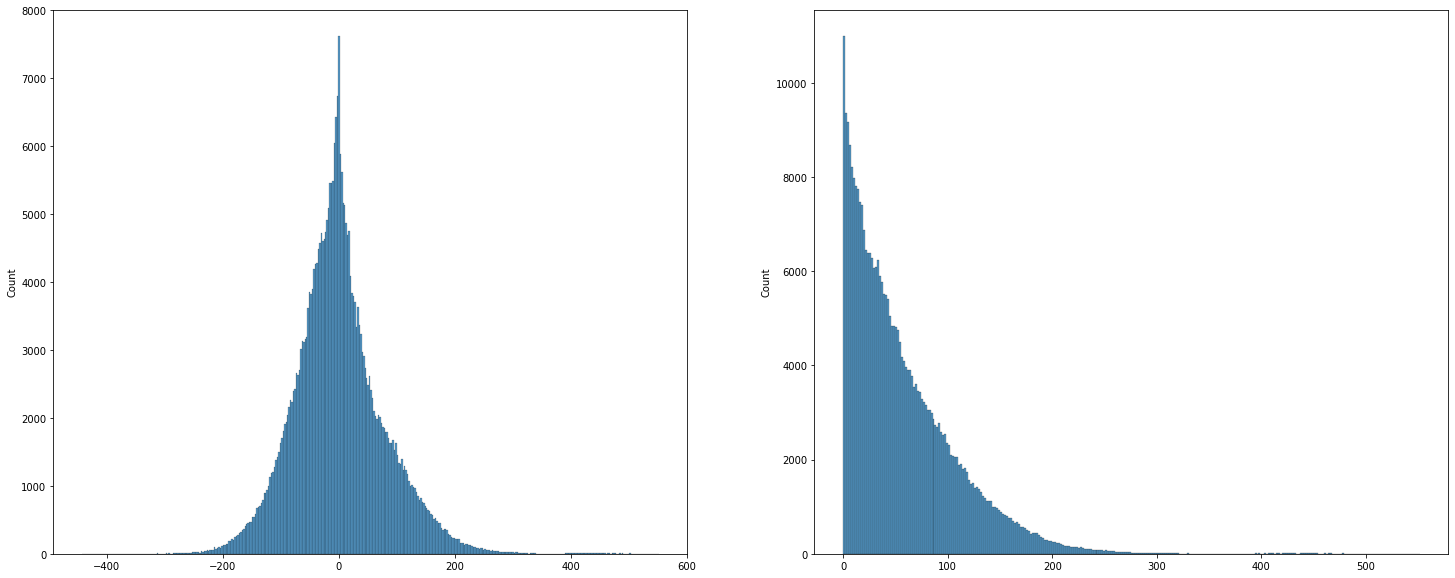

In [90]:
fig, ax = plt.subplots(1,2, figsize=(25, 10))
sns.histplot(errors, ax=ax[0])
sns.histplot(np.abs(errors), ax=ax[1])

In [91]:
s.stdev(errors)

77.37077882799242

In [92]:
np.percentile(errors, 5), np.percentile(errors, 95)

(-118.87167289677268, 137.06867616207435)

In [93]:
abserrors = np.abs(errors)
np.percentile(abserrors, 5), np.percentile(abserrors, 95)

(3.001591153622013, 157.02914189706235)

In [94]:
np.median(abserrors), np.mean(abserrors)

(44.06100819737367, 57.808951611106124)

In [96]:
for k, v in imp_scores.items():
    v.pop("most_ranked")
    v["errors"] = list(v["errors"])

In [97]:
import json
with open("features_ds1.json", "w") as f:
    f.write(json.dumps(imp_scores))

In [98]:
import pickle
with open("features_ds1.sav", "wb") as f:
    pickle.dump(imp_scores, f)